In [1]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path
from sklearn.preprocessing import StandardScaler
import time
import math

In [2]:
# From https://stackoverflow.com/questions/50786266/writing-dictionary-of-dataframes-to-file
import csv
import pandas as pd

def save_dict_df(dictex, keys_filename="keys.txt", data_folder="stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [3]:
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']

In [4]:
#create kw_list 
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [5]:
# Get 3-month ago trend data. May need to run a couple times to make sure it doesn't time out. 
def getTrendDataDF(kw_list, pull_data=False, dates='today 3-m', pytrends_df_filename="pytrends.csv"):
    # Retrieve the cached trend data
    if not pull_data and os.path.isfile(pytrends_df_filename):
        df = pd.read_csv(pytrends_df_filename, index_col="date")
        
    else: # Construct the dataframe by making pytrends calls
        df = pd.DataFrame()
        #print(df.empty)
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            pytrends.build_payload([kw], cat=0, timeframe=dates, geo='', gprop='')
            df_temp = pytrends.interest_over_time()
            df_temp = df_temp.drop(['isPartial'], axis=1)
            # print(kw)
            if df.empty:
                df = df_temp
            else:
                df = df.join(df_temp)
        df.to_csv(pytrends_df_filename)
    #reverse df rows
    df = df.iloc[::-1]
    return df

In [6]:
# Get Stock Daily info for past 100 days
def getDailyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_DAILY'
        api_key = ''
        outputsize = 'compact'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, api_key, outputsize)
            r = requests.get(link)
            data = json.loads(r.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            while "Time Series (Daily)" not in data:
                print("sleeping")
                time.sleep(70)
                link = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, api_key, outputsize)
                r = requests.get(link)
                data = json.loads(r.text)
                
            stock_data_per_day = json.dumps(data["Time Series (Daily)"])
            df_temp = pd.read_json(stock_data_per_day).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [7]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [8]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [9]:
def getOverlapDateData(company_name, dict_stocks, df_trends): 
    new_df_trends = getTrends(company_name, df_trends)
    
    joint_times = getJointTimes(dict_stocks[company_name], new_df_trends)
    
    new_df_stocks = dict_stocks[company_name].loc[dict_stocks[company_name]['times'].isin(joint_times)]
    new_df_stocks = new_df_stocks.reset_index() 
    
    new_df_trends = new_df_trends.loc[new_df_trends.index.isin(joint_times)]
    new_df_trends = new_df_trends.reset_index()
    new_df_trends.columns = ['_'.join(x.split()) for x in list(new_df_trends.columns) if len(x) > 1]
    df_all_data = new_df_stocks.join(new_df_trends)
    return df_all_data


In [10]:
def trainMultipleRegression(y_col, parameter_cols, training_data): 
    formula = y_col + ' ~ 1'
    for i in parameter_cols: 
        formula = formula + " + " + i

    result = sm.formula.ols(formula=formula, data=training_data).fit()
    return result

In [11]:
def plotMultipleRegressionAndGetMSE(company, result, y_col, cols, all_data, training_data, testing_data):
    y_pred = result.predict()
    plt.plot(range(len(all_data[y_col])) , all_data[y_col])
    plt.plot(range(50), result.predict(training_data[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), result.predict(testing_data[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Multiple Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    train_MSE = mean_squared_error(result.predict(training_data[cols]), training_data[y_col])
    test_MSE = mean_squared_error(result.predict(testing_data[cols]), testing_data[y_col])
    print("train MSE:", train_MSE, "test MSE:", test_MSE)
    MSE = test_MSE / (np.mean(training_data[y_col]) )#* np.std(testing_data[y_col]))
    return MSE

In [12]:
def getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train):
    df_all_data_test = df_all_data_train[40:]
    df_all_data_train = df_all_data_train[:40]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 2000, 10):
        clf = Ridge(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))

    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, clf

In [13]:
#ridge regression

def trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, parameter_cols, df_all_data_train, df_all_data_test) : 
    bestAlpha, clf = getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train)
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    
    
    
    #plot data with training and test data
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    
    coef_dict = dict([(b, a) for a,b in sorted(zip(clf.coef_, parameter_cols))])
    coef_df = pd.DataFrame(coef_dict, index=[0]).transpose()
    print(coef_df)
    
    plt.plot(range(len(df_all_data[y_col])) , df_all_data[y_col])
    plt.plot(range(50), clf.predict(df_all_data_train[cols]), '-')
    plt.plot(range(50, len(df_all_data[y_col])), clf.predict(df_all_data_test[cols]), '-')
    plt.xlabel('Day')
    plt.ylabel('Output $ amount')
    plt.title(company + ' Ridge Regression: ' + str(y_col))
    plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    plt.show()
    
    
    MSE = mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]) / (np.mean(df_all_data_train[y_col])) #* np.std(df_all_data_train[y_col]))
    return MSE

In [14]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

In [15]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('profit')
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('mid')
    return cols

## Get data

In [16]:
# Get trend data
df_trends = getTrendDataDF(kw_list, pull_data=False)

In [17]:
# Get stock data
dict_stocks = getDailyStockInfoDict(company_symbol, pull_data=False)

In [18]:
MR = True
RR = True
numTraining = 50

## Predicting with all predictors

tesla
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     94.47
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.59e-13
Time:                        22:53:26   Log-Likelihood:                -122.60
No. Observations:                  50   AIC:                             313.2
Df Residuals:                      16   BIC:                             378.2
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept             

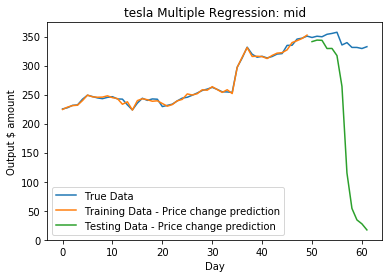

train MSE: 7.895599645952396 test MSE: 34548.500992716145
MSE: 129.12751150766158
alpha: 90
Training error = 111.16128569178935
Testing error = 4394.03545331193

                               0
profit_movingAvg       -2.795971
tesla_down_movingAvg   -2.608931
tesla_bad_movingAvg    -2.082910
tesla_good_movingAvg   -1.801743
profit_prev            -1.548482
tesla_down_stdev       -1.546961
tesla_good             -1.256817
tesla_good_prev        -1.072879
tesla_bad_prev         -0.988391
tesla_bad              -0.336246
tesla_report_movingAvg -0.178502
tesla_down_prev        -0.168845
tesla_down             -0.137481
profit_stdev           -0.036747
tesla_up_stdev         -0.014407
tesla_bad_stdev         0.114004
tesla_report            0.286988
tesla_up_prev           0.323900
tesla_good_stdev        0.398810
tesla_up                0.408994
tesla_report_prev       0.729905
tesla_up_movingAvg      0.875093
volume_prev             1.120031
tesla_report_stdev      1.474319
tesla_stock_p

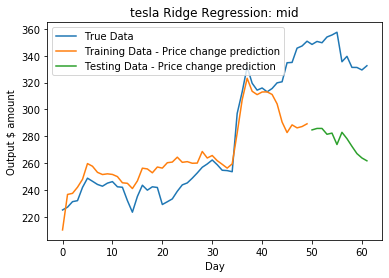

MSE: 16.538245903901277
facebook
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     41.39
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.66e-10
Time:                        22:53:29   Log-Likelihood:                -41.165
No. Observations:                  50   AIC:                             150.3
Df Residuals:                      16   BIC:                             215.3
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

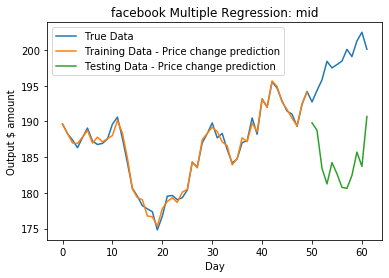

train MSE: 0.30383558892896845 test MSE: 212.70201338496494
MSE: 1.141596500482015
alpha: 1990
Training error = 17.80042748919914
Testing error = 69.95054976599587

                                  0
facebook_report_stdev     -0.060651
mid_stdev                 -0.041667
profit_movingAvg          -0.037304
facebook_report_movingAvg -0.028913
facebook_good_stdev       -0.017181
facebook_report_prev      -0.016798
facebook_up               -0.015498
profit_prev               -0.015136
facebook_good_movingAvg   -0.011752
facebook_up_movingAvg     -0.011745
facebook_report           -0.011551
facebook_up_prev          -0.009399
facebook_bad_movingAvg    -0.007142
profit_stdev              -0.006654
mid_movingAvg             -0.006134
facebook_good_prev        -0.004771
facebook_down_movingAvg   -0.002214
volume_movingAvg           0.002341
facebook_bad_prev          0.004247
facebook_down_prev         0.008583
facebook_up_stdev          0.008955
facebook_good              0.009728
faceboo

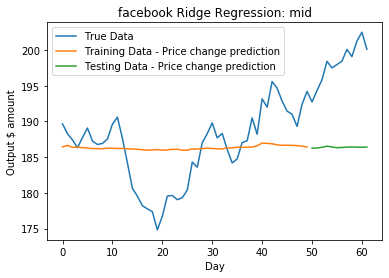

MSE: 0.7866105079916395
microsoft
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     35.49
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           5.44e-10
Time:                        22:53:33   Log-Likelihood:                -21.064
No. Observations:                  50   AIC:                             110.1
Df Residuals:                      16   BIC:                             175.1
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

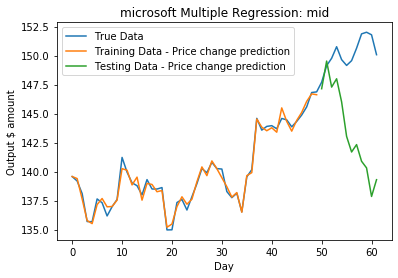

train MSE: 0.1359702852796375 test MSE: 63.59831276449031
MSE: 0.4544554869977394
alpha: 90
Training error = 1.8762423038573093
Testing error = 25.958168069057386

                                   0
microsoft_good_stdev       -0.391804
profit_movingAvg           -0.326601
profit_prev                -0.297363
profit_stdev               -0.246754
volume_prev                -0.237058
microsoft_report_prev      -0.189697
microsoft_good_prev        -0.133499
microsoft_bad_prev         -0.119008
microsoft_up_prev          -0.112487
microsoft_good             -0.109025
microsoft_down             -0.107913
microsoft_up_movingAvg     -0.106210
microsoft_down_prev        -0.101460
microsoft_bad              -0.090649
microsoft_report           -0.088526
microsoft_bad_stdev        -0.077470
microsoft_down_stdev       -0.051859
microsoft_up               -0.029468
volume_movingAvg           -0.025772
microsoft_good_movingAvg   -0.012031
mid_stdev                  -0.000232
microsoft_bad_movingAv

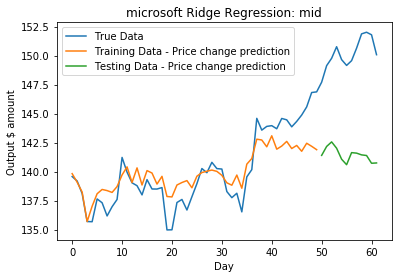

MSE: 0.5593034059924085
amazon
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     15.83
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.42e-07
Time:                        22:53:37   Log-Likelihood:                -163.45
No. Observations:                  50   AIC:                             394.9
Df Residuals:                      16   BIC:                             459.9
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

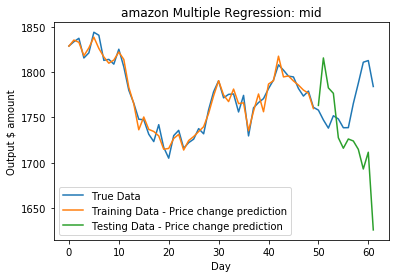

train MSE: 40.459583668107605 test MSE: 5378.278804565248
MSE: 3.030893564889514
alpha: 90
Training error = 606.7846682423469
Testing error = 457.2569403188022

                                0
profit_movingAvg        -4.897281
profit_stdev            -4.139015
amazon_down_stdev       -4.123352
amazon_good_stdev       -3.443507
volume_movingAvg        -2.935082
mid_stdev               -2.496107
amazon_up               -1.978785
amazon_report_stdev     -1.778144
volume_prev             -1.701316
amazon_bad_stdev        -1.676987
amazon_report_movingAvg -1.389868
amazon_up_prev          -1.319601
amazon_report           -1.294032
profit_prev             -1.129452
amazon_bad_movingAvg    -1.005309
amazon_stock            -0.981364
amazon_good_movingAvg   -0.960374
amazon_report_prev      -0.944563
amazon_up_movingAvg     -0.940790
amazon_good_prev        -0.453495
volume_stdev            -0.394217
amazon_stock_prev       -0.161512
amazon_good             -0.012027
mid_movingAvg          

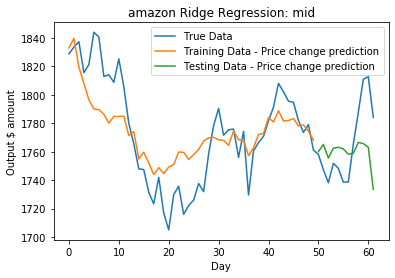

MSE: 0.44247940810332176
google
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     21.73
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.29e-08
Time:                        22:53:41   Log-Likelihood:                -150.08
No. Observations:                  50   AIC:                             368.2
Df Residuals:                      16   BIC:                             433.2
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

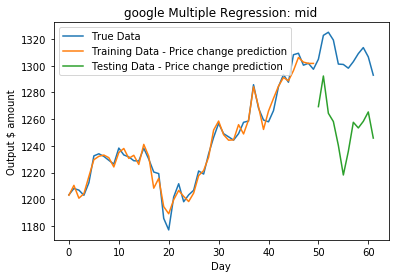

train MSE: 23.69465272158886 test MSE: 3010.9897877967155
MSE: 2.4265121632632507
alpha: 90
Training error = 195.37788671104366
Testing error = 2566.3537364248937

                                0
profit_movingAvg        -4.286174
profit_stdev            -2.881026
google_up               -1.873434
profit_prev             -1.777074
google_report_stdev     -1.657534
google_up_prev          -1.317794
google_report           -1.246131
google_report_prev      -0.721185
google_good             -0.609741
google_up_movingAvg     -0.594307
google_bad              -0.578023
google_bad_prev         -0.568522
google_bad_movingAvg    -0.525107
google_good_prev        -0.470347
google_down             -0.352453
google_down_stdev       -0.166370
google_down_prev        -0.150704
google_down_movingAvg   -0.114315
google_good_movingAvg    0.090161
google_report_movingAvg  0.294295
volume_prev              0.673247
mid_movingAvg            0.932960
google_stock_prev        1.027958
mid_stdev           

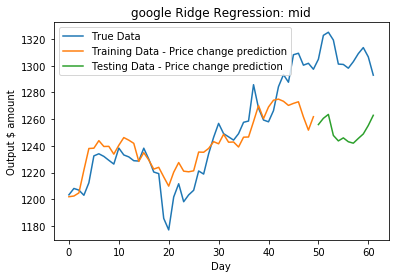

MSE: 2.6832837086457255
uber
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     30.42
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.78e-09
Time:                        22:53:45   Log-Likelihood:                -6.4901
No. Observations:                  50   AIC:                             80.98
Df Residuals:                      16   BIC:                             146.0
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
I

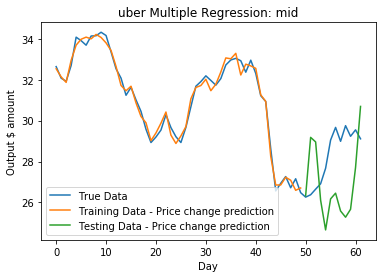

train MSE: 0.07590489584122835 test MSE: 7.644448947433706
MSE: 0.2452467763823934
alpha: 90
Training error = 1.3535752473758709
Testing error = 13.77486500803937

                              0
profit_movingAvg      -0.326972
mid_stdev             -0.190944
volume_stdev          -0.176013
uber_up_stdev         -0.155179
uber_stock            -0.150512
uber_stock_prev       -0.147801
volume_movingAvg      -0.141332
volume_prev           -0.134209
uber_down_movingAvg   -0.127958
uber_stock_movingAvg  -0.125762
uber_stock_stdev      -0.116980
uber_down_stdev       -0.100197
uber_up_movingAvg     -0.086399
uber_up_prev          -0.076248
uber_good_movingAvg   -0.065549
profit_prev           -0.062775
uber_bad_movingAvg    -0.030570
uber_good             -0.027844
uber_up               -0.020787
uber_down_prev        -0.020313
uber_bad_prev         -0.017799
uber_good_prev        -0.016249
uber_report_prev      -0.002076
uber_report_movingAvg -0.001991
uber_bad              -0.000001
uber

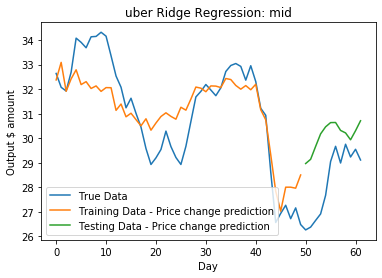

MSE: 0.13783188850840908
lyft
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     16.36
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.90e-07
Time:                        22:53:50   Log-Likelihood:                -32.777
No. Observations:                  50   AIC:                             133.6
Df Residuals:                      16   BIC:                             198.6
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


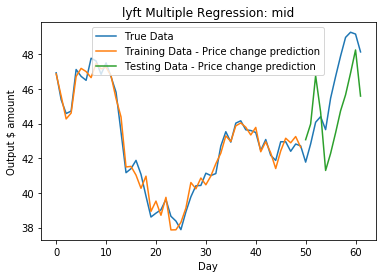

train MSE: 0.21722997492699542 test MSE: 5.863099508854862
MSE: 0.13708465629639185
alpha: 1990
Training error = 8.48248453886495
Testing error = 0.2119457127822451

                              0
lyft_up_movingAvg     -0.039372
lyft_down_stdev       -0.036747
lyft_down_movingAvg   -0.030106
profit_movingAvg      -0.025771
lyft_report_stdev     -0.024189
mid_stdev             -0.021629
lyft_up_prev          -0.020258
lyft_report_movingAvg -0.016637
lyft_good_stdev       -0.015176
lyft_good_movingAvg   -0.012669
lyft_bad_stdev        -0.012062
lyft_up_stdev         -0.011391
lyft_up               -0.011379
mid_movingAvg         -0.008157
lyft_down_prev        -0.007885
profit_prev           -0.006998
lyft_good_prev        -0.003557
lyft_down             -0.003344
lyft_good             -0.002061
lyft_report_prev      -0.001093
lyft_bad              -0.000788
lyft_stock_movingAvg   0.001414
lyft_report            0.002923
lyft_bad_prev          0.003174
profit_stdev           0.005007
ly

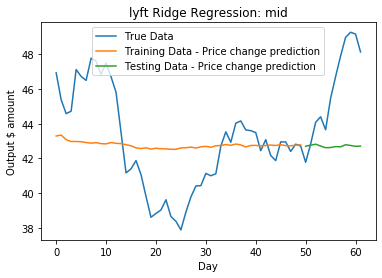

MSE: 0.40930492729705487
apple
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     31.86
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.25e-09
Time:                        22:53:54   Log-Likelihood:                -101.54
No. Observations:                  50   AIC:                             271.1
Df Residuals:                      16   BIC:                             336.1
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

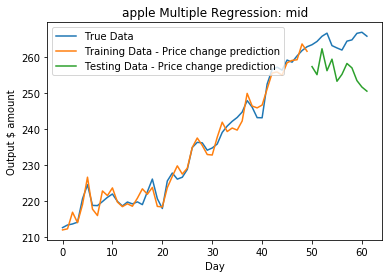

train MSE: 3.399472901386021 test MSE: 93.49240937652472
MSE: 0.40056756067062427
alpha: 90
Training error = 31.8021784078677
Testing error = 662.1519883265927

                               0
apple_up_stdev         -1.697131
apple_bad_stdev        -1.547376
profit_movingAvg       -1.244192
apple_up               -1.047548
profit_prev            -0.852447
apple_stock_stdev      -0.831265
volume_prev            -0.765081
apple_up_prev          -0.576467
apple_bad              -0.409038
volume_stdev           -0.402391
apple_report_stdev     -0.400622
apple_down_prev        -0.379472
volume_movingAvg       -0.315392
apple_bad_prev         -0.285011
apple_good_stdev       -0.218908
apple_report           -0.214520
apple_good             -0.178054
apple_down             -0.175357
apple_good_prev        -0.046223
apple_report_prev      -0.019184
apple_up_movingAvg      0.191698
apple_bad_movingAvg     0.290660
apple_down_stdev        0.423839
apple_down_movingAvg    0.536927
apple_good_mov

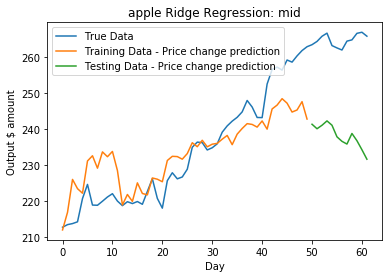

MSE: 3.089944192819993
snap
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     17.77
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.03e-07
Time:                        22:53:59   Log-Likelihood:                 16.311
No. Observations:                  50   AIC:                             35.38
Df Residuals:                      16   BIC:                             100.4
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
In

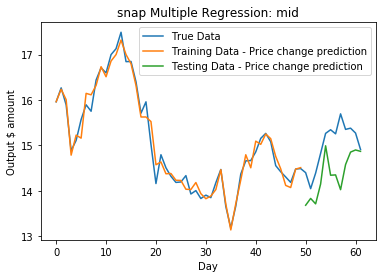

train MSE: 0.03049107093814918 test MSE: 0.5982221389746982
MSE: 0.03971506715260598
alpha: 1990
Training error = 1.1877002346170837
Testing error = 0.38911027574214463

                              0
profit_movingAvg      -0.016510
snap_report_movingAvg -0.012792
snap_good_stdev       -0.011154
snap_report_stdev     -0.010072
snap_stock_stdev      -0.009170
snap_down_movingAvg   -0.009142
snap_good_movingAvg   -0.008312
snap_stock_prev       -0.006976
snap_down_stdev       -0.006620
snap_up_movingAvg     -0.006612
snap_down_prev        -0.006427
snap_up_stdev         -0.005990
profit_prev           -0.005780
snap_good_prev        -0.005617
snap_report_prev      -0.005399
volume_prev           -0.005159
volume_stdev          -0.005079
snap_stock_movingAvg  -0.004962
volume_movingAvg      -0.004803
snap_up_prev          -0.004644
snap_stock            -0.004330
snap_down             -0.004323
snap_up               -0.004260
snap_good             -0.003849
snap_report           -0.00260

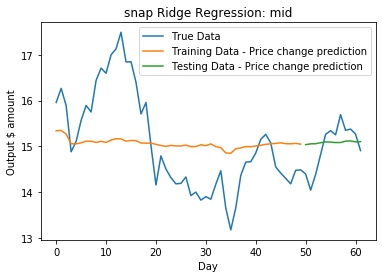

MSE: 0.014527309819694434


In [19]:
MSE_dict = {} # {"company":{"multipleRegressionProfit":value, "multipleRegressionCost":value, etc}}
parameter_type = "allPredictors"
y_col='mid'

# Join data together, train various models
for company in companies: 
    print(company)
    
    # Initialize dictionary 
    MSE_dict[company] = {}
    MSE_dict[company]["MultipleRegression"] = {}
    MSE_dict[company]["RidgeRegression"] = {}
    
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    # Include moving average, stdev, and prev. 10 days. 
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    # Include movingAvg, stdev, and prev for all the Trends cols
    for col in cols: 
        # Prev info
        col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        df_all_data[col+'_prev'] = col_prev
        
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
        
        df_all_data[col+'_movingAvg'] = col_movingAvg
        df_all_data[col+'_stdev'] = col_stdev

    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:numTraining]
    df_all_data_test = df_all_data[numTraining:]
    

    
    if (MR): 
        MSE_dict[company]["MultipleRegression"][parameter_type] = {}


        # Multiple Regression, All Predictors
        
        close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
        print(close_multiple_regression_res.summary())
        MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
        MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    
    if (RR):
        MSE_dict[company]["RidgeRegression"][parameter_type] = {}
        # RIDGE REGRESSION REQUIRES STANDARDIZATION
        # Standardize the input parameters
        df_standardized_data = df_all_data.copy()

        for col in cols: 
            df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)

        # Split into training and testing data
        df_all_data_train = df_standardized_data[:numTraining]
        df_all_data_test = df_standardized_data[numTraining:]

        # Ridge Regression, All Predictors
        MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
        MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    
    


## MR and RR with only Stock Data

                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     14.53
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           4.57e-10
Time:                        22:54:03   Log-Likelihood:                -218.26
No. Observations:                  50   AIC:                             456.5
Df Residuals:                      40   BIC:                             475.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          154.8737     17.599  

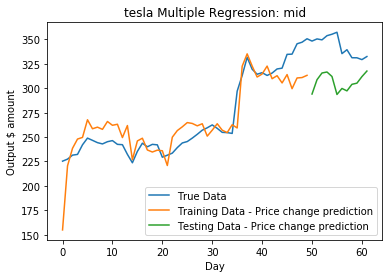

train MSE: 362.2708623702681 test MSE: 1513.7941908341807
MSE: 5.657914849572876
alpha: 90
Training error = 246.54566172446798
Testing error = 4258.9924935782565

                         0
profit_movingAvg -3.364594
profit_prev      -1.948030
profit_stdev      0.049566
volume_prev       2.330413
volume_movingAvg  3.254316
mid_stdev         3.324879
volume_stdev      3.838723
mid_movingAvg     4.660420
mid_prev          6.293647


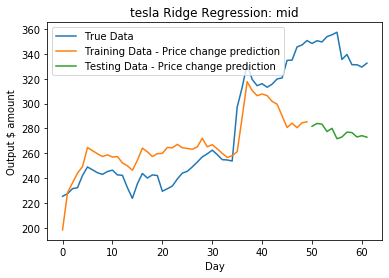

MSE: 16.480926231049246
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     7.668
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.94e-06
Time:                        22:54:07   Log-Likelihood:                -127.56
No. Observations:                  50   AIC:                             275.1
Df Residuals:                      40   BIC:                             294.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept       

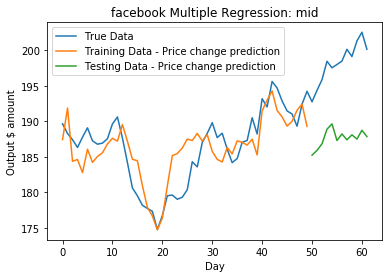

train MSE: 9.628231248746408 test MSE: 116.06790445907819
MSE: 0.6229499732517841
alpha: 1990
Training error = 18.499024510160886
Testing error = 69.24620342141569

                         0
mid_stdev        -0.042100
profit_movingAvg -0.036718
profit_prev      -0.014323
mid_movingAvg    -0.007194
profit_stdev     -0.005559
volume_movingAvg  0.003395
mid_prev          0.010779
volume_prev       0.014869
volume_stdev      0.060493


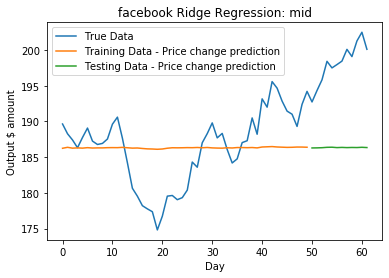

MSE: 0.7919166795353818
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     3.473
Date:                Sun, 08 Dec 2019   Prob (F-statistic):            0.00300
Time:                        22:54:10   Log-Likelihood:                -114.30
No. Observations:                  50   AIC:                             248.6
Df Residuals:                      40   BIC:                             267.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept       

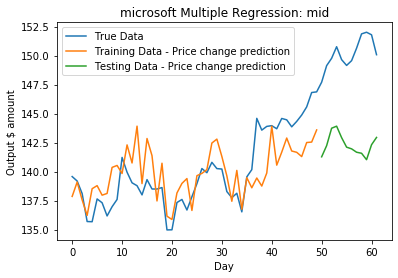

train MSE: 5.663349034029522 test MSE: 64.34220045957187
MSE: 0.45977109727173826
alpha: 90
Training error = 3.6414320508377243
Testing error = 36.13826173419252

                         0
profit_movingAvg -0.408005
profit_prev      -0.363691
volume_prev      -0.241793
profit_stdev     -0.211254
volume_movingAvg  0.069693
mid_movingAvg     0.140044
mid_prev          0.140593
mid_stdev         0.160112
volume_stdev      0.257763


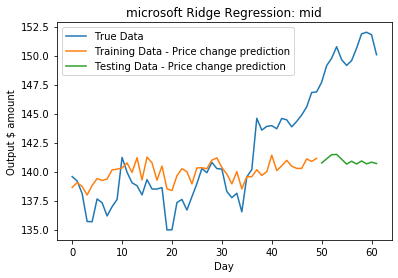

MSE: 0.6227771677874083
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     8.620
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           4.89e-07
Time:                        22:54:13   Log-Likelihood:                -224.41
No. Observations:                  50   AIC:                             468.8
Df Residuals:                      40   BIC:                             487.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept       

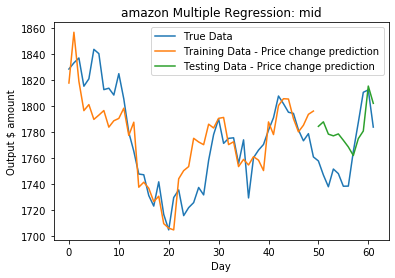

train MSE: 463.28422193489735 test MSE: 763.4077171882899
MSE: 0.43021338638096474
alpha: 1990
Training error = 1487.4656611403664
Testing error = 462.13620015242424

                         0
volume_movingAvg -0.490566
profit_stdev     -0.480949
mid_stdev        -0.440193
profit_movingAvg -0.407901
mid_movingAvg    -0.365480
volume_prev      -0.230754
profit_prev      -0.125942
volume_stdev     -0.098754
mid_prev         -0.057562


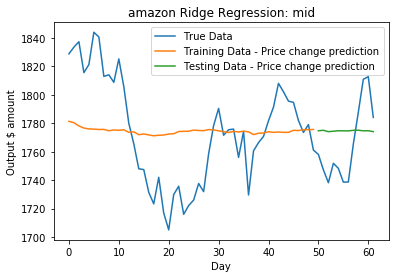

MSE: 0.43399089894593396
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     8.180
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           9.15e-07
Time:                        22:54:17   Log-Likelihood:                -219.60
No. Observations:                  50   AIC:                             459.2
Df Residuals:                      40   BIC:                             478.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept      

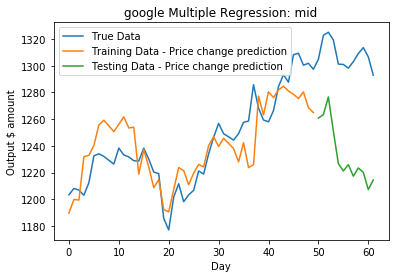

train MSE: 382.2782525593135 test MSE: 5747.860929180141
MSE: 4.632116161246463
alpha: 90
Training error = 339.1615151814707
Testing error = 3170.7459833764265

                         0
profit_movingAvg -5.502334
profit_stdev     -3.144586
profit_prev      -2.224969
volume_prev       1.358549
mid_prev          1.472637
mid_movingAvg     1.832642
mid_stdev         2.205600
volume_movingAvg  3.102340
volume_stdev      4.629675


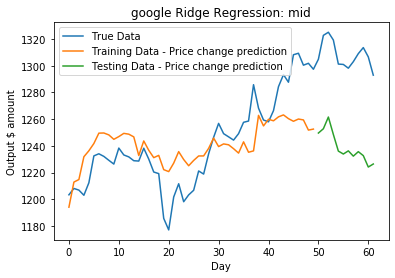

MSE: 3.873599885790793
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     17.59
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.61e-11
Time:                        22:54:21   Log-Likelihood:                -70.328
No. Observations:                  50   AIC:                             160.7
Df Residuals:                      40   BIC:                             179.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        

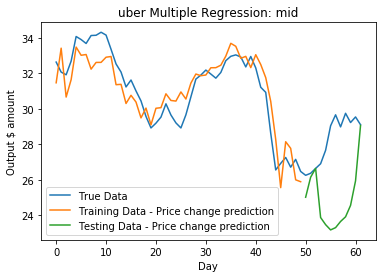

train MSE: 0.9755382526491324 test MSE: 16.675930539110666
MSE: 0.5349918922889196
alpha: 90
Training error = 1.7105095458105233
Testing error = 13.133034784825835

                         0
profit_movingAvg -0.375166
mid_stdev        -0.291628
volume_stdev     -0.284089
volume_prev      -0.267098
volume_movingAvg -0.218468
profit_prev      -0.098501
profit_stdev     -0.058691
mid_movingAvg    -0.000654
mid_prev          0.180305


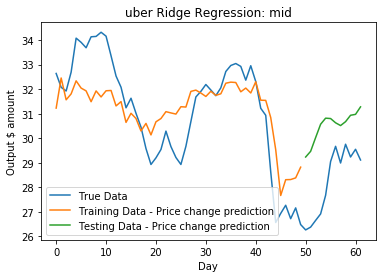

MSE: 0.1865832210260198
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     16.77
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           5.44e-11
Time:                        22:54:24   Log-Likelihood:                -82.408
No. Observations:                  50   AIC:                             184.8
Df Residuals:                      40   BIC:                             203.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept       

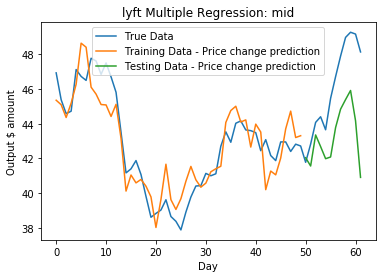

train MSE: 1.5815952353968836 test MSE: 11.550622681199984
MSE: 0.27006417644289116
alpha: 1990
Training error = 9.188189218178215
Testing error = 0.21596972532665365

                         0
profit_movingAvg -0.025808
mid_stdev        -0.023306
mid_movingAvg    -0.011255
profit_prev      -0.006542
profit_stdev      0.003329
volume_stdev      0.008349
volume_movingAvg  0.009840
mid_prev          0.013173
volume_prev       0.013435


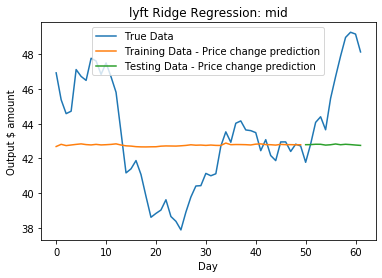

MSE: 0.3973838415940511
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     29.97
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           4.69e-15
Time:                        22:54:28   Log-Likelihood:                -155.38
No. Observations:                  50   AIC:                             330.8
Df Residuals:                      40   BIC:                             349.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept       

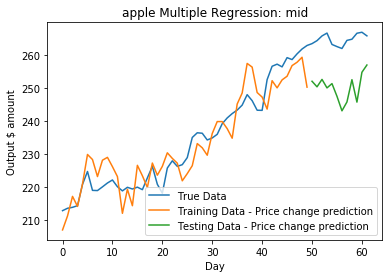

train MSE: 29.287751754871493 test MSE: 222.74716273336495
MSE: 0.9543586288707885
alpha: 90
Training error = 56.047731974820145
Testing error = 646.2529123062819

                         0
profit_movingAvg -1.457727
volume_stdev     -1.144988
volume_prev      -1.032927
profit_prev      -0.927199
volume_movingAvg -0.690287
profit_stdev      1.312246
mid_prev          1.980397
mid_movingAvg     2.084994
mid_stdev         2.208572


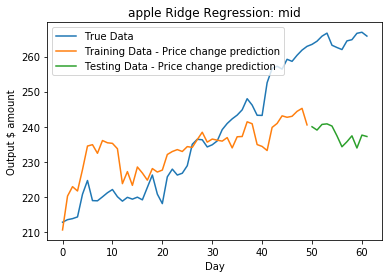

MSE: 3.1317946459026826
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     7.171
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           4.14e-06
Time:                        22:54:31   Log-Likelihood:                -50.382
No. Observations:                  50   AIC:                             120.8
Df Residuals:                      40   BIC:                             139.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept       

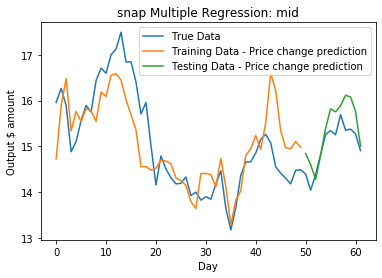

train MSE: 0.43928879680172417 test MSE: 0.19873767900637473
MSE: 0.013193895299526944
alpha: 1990
Training error = 1.2941579990823406
Testing error = 0.3841579055170291

                         0
profit_movingAvg -0.017088
volume_stdev     -0.006178
volume_movingAvg -0.006079
volume_prev      -0.005965
profit_prev      -0.005936
mid_movingAvg    -0.000699
profit_stdev      0.001132
mid_stdev         0.003493
mid_prev          0.008861


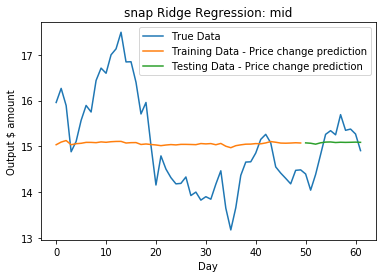

MSE: 0.014977551651593587


In [20]:
# Only Stock Data
parameter_type = "noTrend"
y_col='mid'

for company in companies: 
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    # Include moving average, stdev, and prev. 10 days. 
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    #### Predictions using only stock market data #### 
    # Remove any cols in col that has the company name in it. 
    cols_noTrends = [col for col in cols if company not in col]
    cols = cols_noTrends
    
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:numTraining]
    df_all_data_test = df_all_data[numTraining:]
    
    if (MR): # Multiple Regression
        MSE_dict[company]["MultipleRegression"][parameter_type] = {}
        close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
        print(close_multiple_regression_res.summary())
        MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
        MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    
    if (RR) : # Ridge Regression
        MSE_dict[company]["RidgeRegression"][parameter_type] = {}
        
        # Standardize the input parameters
        df_standardized_data = df_all_data.copy()

        for col in cols: 
            df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)

        # Split into training and testing data
        df_all_data_train = df_standardized_data[:numTraining]
        df_all_data_test = df_standardized_data[numTraining:]

        # Ridge Regression
        MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
        MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    

## Predicting with only Google Trends data

tesla
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     19.40
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           7.52e-11
Time:                        22:54:34   Log-Likelihood:                -180.12
No. Observations:                  50   AIC:                             410.2
Df Residuals:                      25   BIC:                             458.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept             

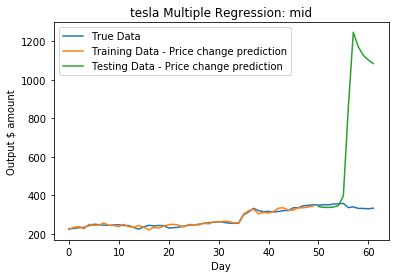

train MSE: 78.80457063964525 test MSE: 300110.4682616695
MSE: 1121.6844965921566
alpha: 90
Training error = 165.97972299179307
Testing error = 5175.850512954081

                               0
tesla_down_movingAvg   -2.520808
tesla_bad_movingAvg    -2.075633
tesla_good             -1.789371
tesla_bad_prev         -1.007814
tesla_good_prev        -0.959131
tesla_down_stdev       -0.908533
tesla_good_movingAvg   -0.738277
tesla_down             -0.322317
tesla_bad              -0.298830
tesla_up_stdev          0.045108
tesla_down_prev         0.078755
tesla_report            0.100558
tesla_up                0.518513
tesla_report_prev       0.533628
tesla_up_prev           0.549931
tesla_good_stdev        1.073275
tesla_bad_stdev         1.102001
tesla_up_movingAvg      1.597960
tesla_report_movingAvg  1.989212
tesla_stock             2.711018
tesla_stock_prev        2.981262
tesla_report_stdev      3.436544
tesla_stock_stdev       4.417604
tesla_stock_movingAvg   6.734797


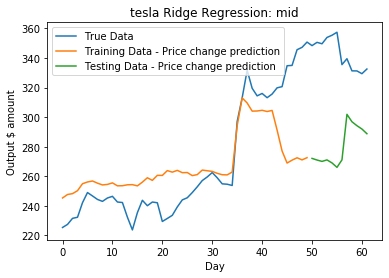

MSE: 16.39098367162132
facebook
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     9.378
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.00e-07
Time:                        22:54:39   Log-Likelihood:                -95.056
No. Observations:                  50   AIC:                             240.1
Df Residuals:                      25   BIC:                             287.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

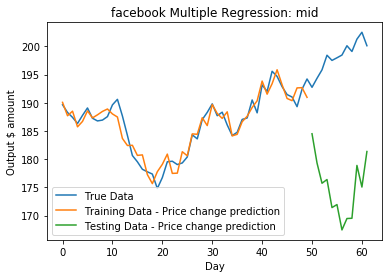

train MSE: 2.6231682165524086 test MSE: 576.8961370281361
MSE: 3.096268816134609
alpha: 90
Training error = 13.27589766362004
Testing error = 63.274495009529424

                                  0
facebook_report_stdev     -0.650057
facebook_report_movingAvg -0.374132
facebook_good_stdev       -0.363750
facebook_report_prev      -0.124979
facebook_up               -0.115359
facebook_report           -0.099907
facebook_good_movingAvg   -0.098705
facebook_good_prev        -0.088274
facebook_up_prev          -0.072350
facebook_up_movingAvg     -0.066950
facebook_bad_movingAvg    -0.025145
facebook_down_movingAvg    0.012953
facebook_bad_prev          0.035381
facebook_good              0.037251
facebook_down_prev         0.072137
facebook_bad               0.098920
facebook_down              0.168023
facebook_stock_prev        0.196924
facebook_bad_stdev         0.230795
facebook_up_stdev          0.307273
facebook_stock_movingAvg   0.348219
facebook_stock             0.371285
facebook_d

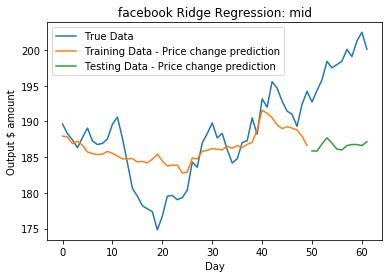

MSE: 0.7534772661237196
microsoft
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     14.20
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.44e-09
Time:                        22:54:43   Log-Likelihood:                -61.648
No. Observations:                  50   AIC:                             173.3
Df Residuals:                      25   BIC:                             221.1
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

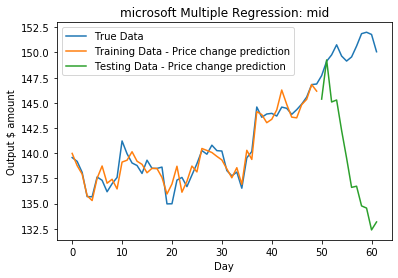

train MSE: 0.6893949958353807 test MSE: 152.0133131008688
MSE: 1.0862439777485318
alpha: 90
Training error = 2.4808627373850554
Testing error = 28.57601116968098

                                   0
microsoft_good_stdev       -0.425615
microsoft_report_prev      -0.244105
microsoft_down             -0.159392
microsoft_down_prev        -0.149794
microsoft_good_prev        -0.132715
microsoft_good             -0.120184
microsoft_bad_prev         -0.118193
microsoft_up_prev          -0.105884
microsoft_up_movingAvg     -0.101013
microsoft_bad              -0.091311
microsoft_report           -0.090812
microsoft_down_stdev       -0.077849
microsoft_bad_stdev        -0.076997
microsoft_up               -0.053025
microsoft_good_movingAvg   -0.012675
microsoft_bad_movingAvg     0.031777
microsoft_report_movingAvg  0.093564
microsoft_down_movingAvg    0.101992
microsoft_report_stdev      0.165912
microsoft_up_stdev          0.205396
microsoft_stock_prev        0.231368
microsoft_stock_stdev  

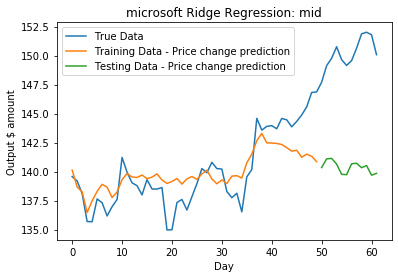

MSE: 0.6996087147083634
amazon
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     3.944
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           0.000559
Time:                        22:54:47   Log-Likelihood:                -212.22
No. Observations:                  50   AIC:                             474.4
Df Residuals:                      25   BIC:                             522.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

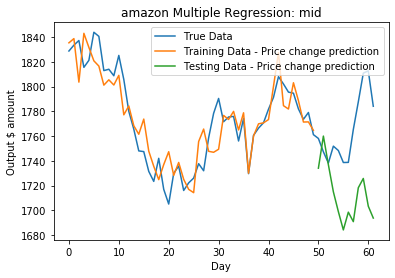

train MSE: 284.510546966549 test MSE: 3911.6886411685023
MSE: 2.2044063465630233
alpha: 1990
Training error = 1448.852309335815
Testing error = 469.9830377399554

                                0
amazon_down_stdev       -0.442974
amazon_good_stdev       -0.383884
amazon_bad_movingAvg    -0.370059
amazon_report_movingAvg -0.355466
amazon_up_movingAvg     -0.350702
amazon_report_stdev     -0.338991
amazon_good_movingAvg   -0.334732
amazon_bad_stdev        -0.307654
amazon_down_movingAvg   -0.273508
amazon_up_prev          -0.218645
amazon_report_prev      -0.184427
amazon_stock_movingAvg  -0.168755
amazon_up               -0.155413
amazon_good_prev        -0.124836
amazon_report           -0.115660
amazon_bad_prev         -0.106844
amazon_stock_prev       -0.094654
amazon_stock            -0.080889
amazon_bad               0.003130
amazon_down_prev         0.005125
amazon_good              0.015757
amazon_stock_stdev       0.052940
amazon_up_stdev          0.145790
amazon_down          

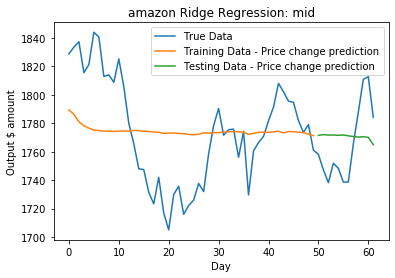

MSE: 0.42966327930783094
google
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     14.69
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.69e-09
Time:                        22:54:51   Log-Likelihood:                -177.84
No. Observations:                  50   AIC:                             405.7
Df Residuals:                      25   BIC:                             453.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

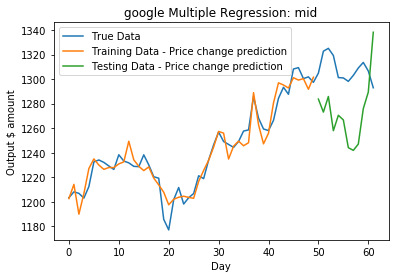

train MSE: 71.91839056464934 test MSE: 2048.2568547970336
MSE: 1.6506599231242183
alpha: 90
Training error = 281.6824569919674
Testing error = 2808.479215689303

                                0
google_report_stdev     -2.144097
google_up               -2.114448
google_report           -1.961028
google_up_prev          -0.979965
google_report_prev      -0.868047
google_bad              -0.685470
google_up_movingAvg     -0.501423
google_bad_movingAvg    -0.486701
google_bad_prev         -0.426883
google_good             -0.405218
google_good_prev        -0.150734
google_down_movingAvg   -0.040547
google_good_movingAvg    0.220278
google_down_prev         0.354603
google_report_movingAvg  0.362178
google_down              0.387260
google_down_stdev        0.601563
google_stock_prev        1.765281
google_bad_stdev         2.110584
google_stock_movingAvg   3.332826
google_stock             3.492873
google_good_stdev        3.512292
google_stock_stdev       4.105079
google_up_stdev       

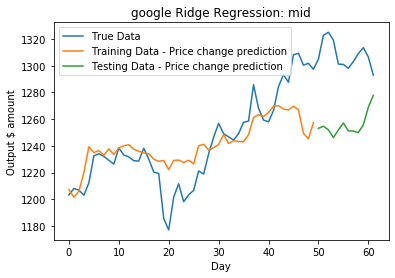

MSE: 2.398288443373069
uber
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     7.177
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           2.87e-06
Time:                        22:54:55   Log-Likelihood:                -58.716
No. Observations:                  50   AIC:                             167.4
Df Residuals:                      25   BIC:                             215.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
In

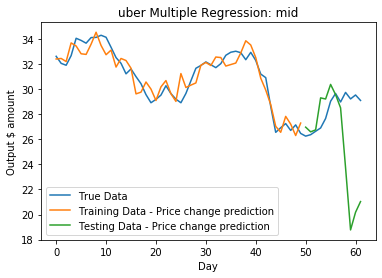

train MSE: 0.6130986275391378 test MSE: 25.799781598280987
MSE: 0.8277003760319869
alpha: 630
Training error = 2.425238132044212
Testing error = 15.995445077192997

                              0
uber_stock_prev       -0.077874
uber_stock_stdev      -0.076487
uber_up_stdev         -0.068971
uber_stock            -0.068289
uber_stock_movingAvg  -0.067271
uber_down_movingAvg   -0.055523
uber_down_stdev       -0.038441
uber_good_movingAvg   -0.038393
uber_report_movingAvg -0.034696
uber_up_movingAvg     -0.034126
uber_bad_stdev        -0.032054
uber_bad_prev         -0.029348
uber_bad_movingAvg    -0.022533
uber_bad              -0.020562
uber_report_prev      -0.016050
uber_up_prev          -0.015120
uber_good_prev        -0.011678
uber_down_prev        -0.009514
uber_good_stdev       -0.009272
uber_good             -0.006566
uber_up               -0.000102
uber_down              0.000614
uber_report            0.002988
uber_report_stdev      0.015319


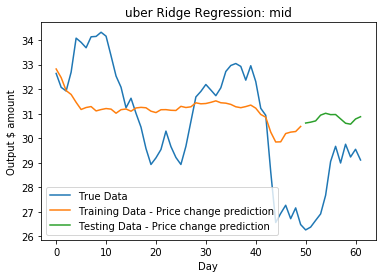

MSE: 0.25893099205482417
lyft
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     15.08
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           1.27e-09
Time:                        22:55:00   Log-Likelihood:                -53.001
No. Observations:                  50   AIC:                             156.0
Df Residuals:                      25   BIC:                             203.8
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


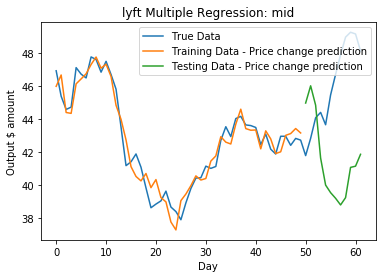

train MSE: 0.48780915137215153 test MSE: 40.29694081008555
MSE: 0.9421795199627355
alpha: 1990
Training error = 8.66986482147843
Testing error = 0.21335371363655833

                              0
lyft_up_movingAvg     -0.039294
lyft_down_stdev       -0.036763
lyft_down_movingAvg   -0.030236
lyft_report_stdev     -0.023983
lyft_up_prev          -0.020145
lyft_report_movingAvg -0.016287
lyft_good_stdev       -0.015055
lyft_good_movingAvg   -0.012358
lyft_bad_stdev        -0.011837
lyft_up               -0.011436
lyft_up_stdev         -0.011085
lyft_down_prev        -0.007891
lyft_down             -0.003575
lyft_good_prev        -0.003414
lyft_good             -0.002070
lyft_report_prev      -0.000787
lyft_bad              -0.000441
lyft_stock_movingAvg   0.001850
lyft_report            0.002943
lyft_bad_prev          0.003271
lyft_stock_prev        0.007318
lyft_stock             0.013668
lyft_stock_stdev       0.015786
lyft_bad_movingAvg     0.019566


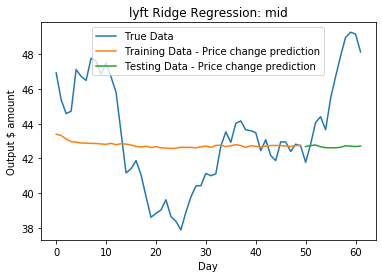

MSE: 0.414211461592467
apple
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     9.014
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           3.00e-07
Time:                        22:55:04   Log-Likelihood:                -149.86
No. Observations:                  50   AIC:                             349.7
Df Residuals:                      25   BIC:                             397.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

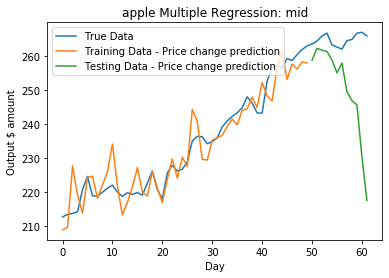

train MSE: 23.491568542136974 test MSE: 401.42606643525977
MSE: 1.7199071164589248
alpha: 90
Training error = 46.40049238878679
Testing error = 781.9008933142261

                               0
apple_up_stdev         -2.331984
apple_bad_stdev        -1.769928
apple_up               -1.615470
apple_bad              -0.776128
apple_stock_stdev      -0.725653
apple_up_prev          -0.706165
apple_report_stdev     -0.412641
apple_report           -0.393826
apple_bad_prev         -0.296513
apple_down             -0.283341
apple_down_prev        -0.272450
apple_report_prev      -0.133918
apple_good             -0.045135
apple_good_stdev       -0.011128
apple_good_prev         0.352960
apple_up_movingAvg      0.504368
apple_down_stdev        0.541755
apple_stock             0.633249
apple_bad_movingAvg     0.811157
apple_stock_prev        0.851742
apple_down_movingAvg    1.055600
apple_good_movingAvg    1.156619
apple_report_movingAvg  1.388789
apple_stock_movingAvg   1.643959


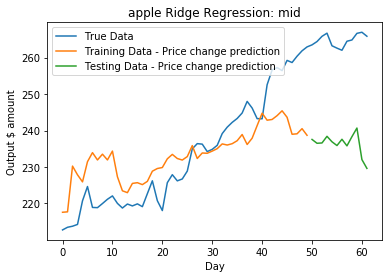

MSE: 3.514060786213119
snap
                            OLS Regression Results                            
Dep. Variable:                    mid   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     11.22
Date:                Sun, 08 Dec 2019   Prob (F-statistic):           3.08e-08
Time:                        22:55:08   Log-Likelihood:                -12.749
No. Observations:                  50   AIC:                             75.50
Df Residuals:                      25   BIC:                             123.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
In

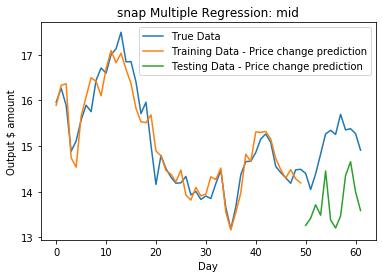

train MSE: 0.09749778977736206 test MSE: 1.8771372707677283
MSE: 0.12462031728042243
alpha: 1990
Training error = 1.2414662077935956
Testing error = 0.36865930777395334

                              0
snap_report_movingAvg -0.013030
snap_good_stdev       -0.011198
snap_report_stdev     -0.010303
snap_stock_stdev      -0.009450
snap_down_movingAvg   -0.009256
snap_good_movingAvg   -0.008294
snap_stock_prev       -0.007241
snap_down_stdev       -0.006764
snap_up_movingAvg     -0.006598
snap_down_prev        -0.006590
snap_up_stdev         -0.005950
snap_good_prev        -0.005663
snap_report_prev      -0.005473
snap_stock_movingAvg  -0.005049
snap_up_prev          -0.004525
snap_stock            -0.004495
snap_down             -0.004367
snap_up               -0.004220
snap_good             -0.003915
snap_report           -0.002567
snap_bad               0.000076
snap_bad_stdev         0.000674
snap_bad_prev          0.001021
snap_bad_movingAvg     0.004157


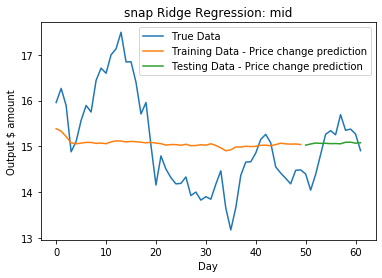

MSE: 0.015040224748814595


In [21]:
# Join data together, train various models
parameter_type="onlyTrends"
y_col='mid'
for company in companies: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    num_days_to_average = 10
    for col in cols: 
        # Prev to today increment amount
        col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        df_all_data[col+'_prev'] = col_prev
        
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
        
        df_all_data[col+'_movingAvg'] = col_movingAvg
        df_all_data[col+'_stdev'] = col_stdev

    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:numTraining]
    df_all_data_test = df_all_data[numTraining:]
    
    if (MR): 
        MSE_dict[company]["MultipleRegression"][parameter_type] = {}
        # Profit prediction: 
        close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
        print(close_multiple_regression_res.summary())
        MSE = plotMultipleRegressionAndGetMSE(company, close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
        MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    
    if (RR): 
        MSE_dict[company]["RidgeRegression"][parameter_type] = {}
        # Standardize the input parameters
        df_standardized_data = df_all_data.copy()

        for col in cols: 
            df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)

        # Split into training and testing data
        df_all_data_train = df_standardized_data[:numTraining]
        df_all_data_test = df_standardized_data[numTraining:]

        # Ridge Regression
        MSE = trainAndPlotRidgeRegressionAndReturnMSE(company, y_col, cols, df_all_data_train, df_all_data_test)
        MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
        print("MSE:", MSE)
    

In [22]:
def plotMSE(y_col, model):
    numBetter = 0
    totalCompanies = 0
    for company in companies[0:2] + companies[2:]:
        allPredictors = MSE_dict[company][model]['allPredictors'][y_col]
        onlyTrends = MSE_dict[company][model]['onlyTrends'][y_col]
        noTrends = MSE_dict[company][model]['noTrend'][y_col]
        plt.plot(["all predictors", "only trends", "only stocks"], [allPredictors, onlyTrends, noTrends], label=company)
        
        if(allPredictors < noTrends) or (onlyTrends < noTrends):
            numBetter += 1
            print(">>", company,[allPredictors, onlyTrends, noTrends])
        else : print("  ",company,[allPredictors, onlyTrends, noTrends])

        totalCompanies += 1
    print("numBetter:", numBetter, "out of:",  totalCompanies)
    print("percent better:", numBetter / totalCompanies)

    
    # plt.xlabel("parameter types")
    plt.ylabel("MSE / mean stock price")
    plt.legend()
    plt.title("Daily " + model + " " + y_col)
    
    
    

   tesla [129.12751150766158, 1121.6844965921566, 5.657914849572876]
   facebook [1.141596500482015, 3.096268816134609, 0.6229499732517841]
>> microsoft [0.4544554869977394, 1.0862439777485318, 0.45977109727173826]
   amazon [3.030893564889514, 2.2044063465630233, 0.43021338638096474]
>> google [2.4265121632632507, 1.6506599231242183, 4.632116161246463]
>> uber [0.2452467763823934, 0.8277003760319869, 0.5349918922889196]
>> lyft [0.13708465629639185, 0.9421795199627355, 0.27006417644289116]
>> apple [0.40056756067062427, 1.7199071164589248, 0.9543586288707885]
   snap [0.03971506715260598, 0.12462031728042243, 0.013193895299526944]
numBetter: 5 out of: 9
percent better: 0.5555555555555556


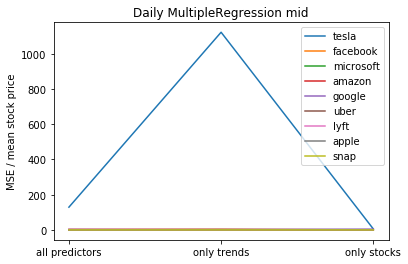

In [23]:
y_col = "mid"
model = "MultipleRegression"
plotMSE(y_col, model)


>> tesla [16.538245903901277, 16.39098367162132, 16.480926231049246]
>> facebook [0.7866105079916395, 0.7534772661237196, 0.7919166795353818]
>> microsoft [0.5593034059924085, 0.6996087147083634, 0.6227771677874083]
>> amazon [0.44247940810332176, 0.42966327930783094, 0.43399089894593396]
>> google [2.6832837086457255, 2.398288443373069, 3.873599885790793]
>> uber [0.13783188850840908, 0.25893099205482417, 0.1865832210260198]
   lyft [0.40930492729705487, 0.414211461592467, 0.3973838415940511]
>> apple [3.089944192819993, 3.514060786213119, 3.1317946459026826]
>> snap [0.014527309819694434, 0.015040224748814595, 0.014977551651593587]
numBetter: 8 out of: 9
percent better: 0.8888888888888888


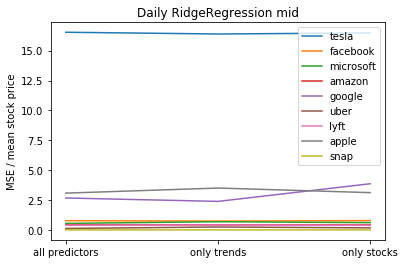

In [24]:
y_col = "mid"
model = "RidgeRegression"
plotMSE(y_col, model)



## Tensorflow + Keras time

In [25]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [26]:
df_all_data['mid'] = (df_all_data['high'] + df_all_data['low'])/2
df_all_data[cols+['mid']]

,snap_report,snap_good,snap_bad,snap_up,snap_down,snap_stock,snap_report_prev,snap_report_movingAvg,snap_report_stdev,snap_good_prev,...,snap_up_prev,snap_up_movingAvg,snap_up_stdev,snap_down_prev,snap_down_movingAvg,snap_down_stdev,snap_stock_prev,snap_stock_movingAvg,snap_stock_stdev,mid
61,0,43,15,50,18,28,0,0.000000,0.000000,0,...,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,15.95995
60,45,50,16,47,15,24,0,0.000000,0.000000,43,...,50,0.000000,0.000000,18,0.000000,0.000000,28,0.000000,0.000000,16.26750
59,43,43,30,56,100,30,45,22.500000,0.000000,50,...,47,23.500000,0.000000,15,7.500000,0.000000,24,12.000000,0.000000,15.89250
58,34,74,76,76,20,33,43,29.333333,1.000000,43,...,56,34.333333,4.500000,100,38.333333,42.500000,30,18.000000,3.000000,14.88500
57,34,54,52,75,27,35,34,30.500000,4.784233,74,...,76,44.750000,12.119773,20,33.750000,38.944405,33,21.750000,3.741657,15.11000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,42,57,44,86,11,26,44,34.111111,10.185007,55,...,66,69.666667,8.673775,33,24.777778,8.922409,33,21.888889,5.743203,15.69500
3,25,16,22,88,14,25,42,33.222222,9.353308,57,...,86,69.444444,8.417801,11,21.888889,9.707439,26,21.888889,5.743203,15.35300
2,69,26,29,92,20,24,25,30.444444,8.771402,16,...,88,70.666667,9.000000,14,18.777778,7.639331,25,23.111111,4.123106,15.38000
1,26,32,23,78,12,8,69,34.333333,14.447643,26,...,92,72.333333,9.809912,20,18.666667,7.648529,24,23.111111,4.123106,15.27250


In [27]:
#scale data to be between 0-1 
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_standardized_data[cols+['mid']])


In [28]:
# Get training and test set
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(50, 1, 24) (50,) (12, 1, 24) (12,)


In [29]:
# Create a sequential NN

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [30]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

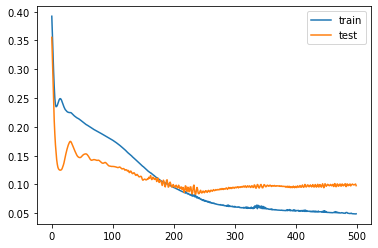

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

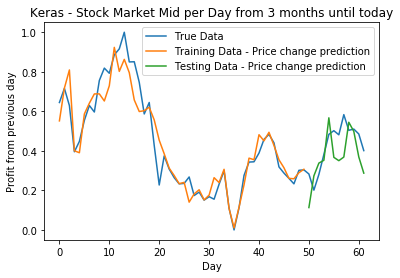

In [32]:
plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(len(train_y)), model.predict(train_X), '-', range(len(train_y), len(train_y)+len(test_y)), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('Keras - Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [33]:
df_stocks['microsoft']

NameError: name 'df_stocks' is not defined

In [ ]:
df_msft = df_stocks['microsoft'][['high', 'low']].iloc[::-1]
df_msft['mid'] = (df_msft['high'] + df_msft['low']) /2

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_msft[['high', 'low', 'mid']])

In [ ]:
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(100) , list(np.array(train_y))+list(np.array(test_y)), range(50), model.predict(train_X), '-', range(50, 100), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('MSFT Keras- Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [ ]:
msft_names = [x for x in list(df.columns.values) if 'microsoft' in x]
df_msft_trends = df[msft_names]
stock_times = df_stocks['microsoft'].times
trends_times = list(df_msft_trends.index)
joint_times = list(set(stock_times) & set(trends_times)) 
df_stocks['microsoft'] = df_stocks['microsoft'].loc[df_stocks['microsoft']['times'].isin(joint_times)]
df_stocks['microsoft'] = df_stocks['microsoft'].reset_index()
print(df_stocks['microsoft'].head())
df_msft_trends = df_msft_trends.loc[df_msft_trends.index.isin(joint_times)]
df_msft_trends = df_msft_trends.reset_index()
df_msft_trends.columns = ['_'.join(x.split()) for x in list(df_msft_trends.columns) if len(x) > 1]
print(df_msft_trends.head())
df_msft = df_msft_trends.join(df_stocks['microsoft'])
df_msft['profit'] = df_msft['open']-df_msft['close']
df_msft = df_msft.iloc[::-1]
df_msft.head()

In [ ]:
cols = ['microsoft_'+ x for x in key_terms]
df_msft['mid'] = (df_fb['high'] + df_fb['low'])/2
df_msft[cols+['high', 'low']+['mid']]

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_msft[cols+['high', 'low', 'mid']])

In [ ]:
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(50), model.predict(train_X), '-', range(50, len(train_y)+len(test_y)), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('MSFT Keras- Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()